In [26]:
import pandas as pd
import json
from environs import Env
from neo4j import GraphDatabase
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import operator
import requests

In [121]:
env = Env()
env.read_env()

EPIGRAPHDB_SERVER = env.str("EPIGRAPHDB_SERVER")
EPIGRAPHDB_USER = "neo4j"
EPIGRAPHDB_PORT = env.str("EPIGRAPHDB_PORT")
EPIGRAPHDB_PASSWORD = env.str("EPIGRAPHDB_PASSWORD")
print(EPIGRAPHDB_PORT)

epigraphdb_driver = GraphDatabase.driver(
    "bolt://{server_name}:{port}".format(
        server_name=EPIGRAPHDB_SERVER, port=EPIGRAPHDB_PORT),
    auth=(EPIGRAPHDB_USER, EPIGRAPHDB_PASSWORD))

session = epigraphdb_driver.session()

37687


In [65]:
def query_to_df(query):
    print(query)
    data=session.run(query).data()
    df = pd.json_normalize(data)
    return(df)

## Get GWAS with available full summary data

In [87]:
query="""
MATCH (gwas:Gwas) -[gwas_to_variant:GWAS_TO_VARIANT]->(variant:Variant)
where toLower(gwas.trait) contains "breast"
return distinct gwas.trait, gwas.id, gwas_to_variant.samplesize as SampleSize,
toInteger(gwas.ncase) as N_case, toInteger(gwas.ncontrol) as N_control, gwas.author
order by gwas_to_variant.samplesize desc
"""
df = query_to_df(query)
df


MATCH (gwas:Gwas) -[gwas_to_variant:GWAS_TO_VARIANT]->(variant:Variant)
where toLower(gwas.trait) contains "breast"
return distinct gwas.trait, gwas.id, gwas_to_variant.samplesize as SampleSize,
toInteger(gwas.ncase) as N_case, toInteger(gwas.ncontrol) as N_control, gwas.author
order by gwas_to_variant.samplesize desc



,gwas.trait,gwas.id,SampleSize,N_case,N_control,gwas.author
0,Diagnoses - main ICD10: C50 Malignant neoplasm...,ukb-a-519,337199,5510,331689,Neale
1,Cancer code self-reported: breast cancer,ukb-a-55,337159,7480,329679,Neale
2,Illnesses of mother: Breast cancer,ukb-a-213,308780,25865,283784,Neale
3,Breastfed as a baby,ukb-a-33,255881,181621,74260,Neale
4,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,228951,122977,105974,Michailidou K
5,ER+ Breast cancer (Combined Oncoarray; iCOGS; ...,ieu-a-1127,175475,69501,105974,Michailidou K
6,ER- Breast cancer (Combined Oncoarray; iCOGS; ...,ieu-a-1128,127442,21468,105974,Michailidou K
7,Breast cancer (Oncoarray),ieu-a-1129,106776,61282,45494,Michailidou K
8,Breast cancer (iCOGS),ieu-a-1130,89677,46785,42892,Michailidou K
9,ER+ Breast cancer (Oncoarray),ieu-a-1132,83691,38197,45494,Michailidou K


## Test gwas->variant->gene->protein->pathway

In [72]:
# for major GWAS

def get_gwas_to_pathway(GWAS_ID):
    query = """
    MATCH (gwas:Gwas) -[gwas_to_variant:GWAS_TO_VARIANT]->(variant:Variant)-[variant_to_gene:VARIANT_TO_GENE]-> (gene:Gene)-[gene_to_protein:GENE_TO_PROTEIN]->(protein:Protein) -[protein_in_pathway:PROTEIN_IN_PATHWAY]->(pathway:Pathway) 
    WHERE gwas.id = '{gwas_id}' AND gwas_to_variant.pval < 1e-08 
    AND gene.name is not null 
    RETURN gwas.id, gwas_to_variant.beta, gwas_to_variant.pval, gwas_to_variant.samplesize as sampleSize,
           variant.name, gene.name, protein.uniprot_id, 
           collect (pathway.name) as Pathways, count (pathway.name) as N_pathways 
    ORDER BY gwas_to_variant.pval
    """.format(gwas_id=GWAS_ID)

    df = query_to_df(query)
    return df

bc_all = get_gwas_to_pathway(GWAS_ID = 'ieu-a-1126')
print(bc_all.shape[0])
bc_er_pos = get_gwas_to_pathway(GWAS_ID = 'ieu-a-1127')
print(bc_er_pos.shape[0])
bc_er_neg = get_gwas_to_pathway(GWAS_ID = 'ieu-a-1128')
print(bc_er_neg.shape[0])


53
42
17


In [73]:
bc_all

,gwas.id,gwas_to_variant.beta,gwas_to_variant.pval,sampleSize,variant.name,gene.name,protein.uniprot_id,Pathways,N_pathways
0,ieu-a-1126,-0.2030,1.000000e-200,228951,rs7895676,FGFR2,P21802,"[Signaling by FGFR2 fusions, Signaling by FGFR...",9
1,ieu-a-1126,-0.0968,6.501297e-42,228951,rs11624333,RAD51B,O15315,[Factors involved in megakaryocyte development...,12
2,ieu-a-1126,0.1206,9.038576e-35,228951,rs5995875,MKL1,Q969V6,"[Post-translational protein modification, RHO ...",9
3,ieu-a-1126,-0.0717,4.680584e-31,228951,rs11135046,EBF1,Q9UH73,[Transcriptional regulation of white adipocyte...,2
4,ieu-a-1126,0.0663,1.307073e-26,228951,rs2747652,ESR1,P03372,"[Estrogen-dependent gene expression, Extra-nuc...",34
5,ieu-a-1126,-0.0624,3.500258e-23,228951,rs62048402,FTO,Q9C0B1,[Reversal of alkylation damage by DNA dioxygen...,3
6,ieu-a-1126,-0.0651,4.046691e-21,228951,rs2853669,TERT,O14746,"[Chromosome Maintenance, Formation of the beta...",9
7,ieu-a-1126,-0.0615,2.381771e-20,228951,rs2506889,PEX14,O75381,"[Protein localization, Class I peroxisomal mem...",7
8,ieu-a-1126,-0.0586,3.874360e-20,228951,rs1685191,KCNN4,O15554,"[Potassium Channels, Ca2+ activated K+ channel...",3
9,ieu-a-1126,0.0567,9.074026e-19,228951,rs6787391,ITPR1,Q14643,"[Signaling by the B Cell Receptor (BCR), Antig...",50


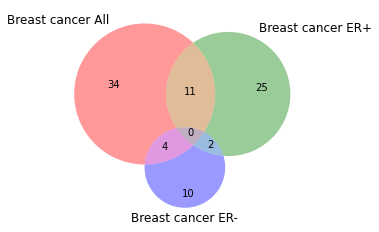

In [107]:
from matplotlib_venn import venn3
from matplotlib import pyplot as plt
%matplotlib inline

# variants
venn3([set(bc_all["variant.name"]), set(bc_er_pos["variant.name"]), set(bc_er_neg["variant.name"])],
      set_labels=('Breast cancer All', 'Breast cancer ER+', 'Breast cancer ER-'))
plt.show()

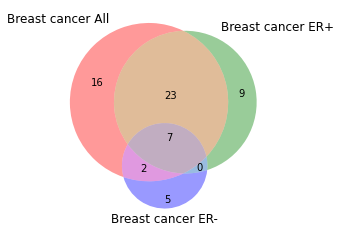

In [108]:
#genes
venn3([set(bc_all["gene.name"]), set(bc_er_pos["gene.name"]), set(bc_er_neg["gene.name"])],
      set_labels=('Breast cancer All', 'Breast cancer ER+', 'Breast cancer ER-'))
plt.show()

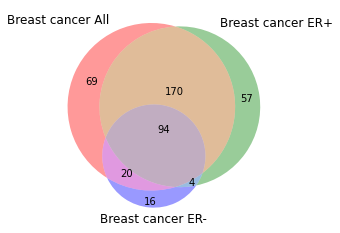

In [118]:
# pathways
def flatten(nested_list):
    flat_list = [item for sublist in list(nested_list) for item in sublist]
    return set(flat_list)

venn3([flatten(bc_all["Pathways"]),
      flatten(bc_er_pos["Pathways"]), 
      flatten(bc_er_neg["Pathways"])],
      set_labels=('Breast cancer All', 'Breast cancer ER+', 'Breast cancer ER-'))
plt.show()


## Test gwas->variant->gene->tissue (expressed in)

In [56]:
# for major GWAS

def get_gwas_to_tissue(GWAS_ID):
    query = """
    MATCH (gwas:Gwas) -[gwas_to_variant:GWAS_TO_VARIANT]->(variant:Variant)-[variant_to_gene:VARIANT_TO_GENE]-> (gene:Gene)-[gene_to_tissue:EXPRESSED_IN]->(tissue:Tissue) 
    WHERE gwas.id = '{gwas_id}' AND gwas_to_variant.pval < 1e-08 
    AND gene.name is not null 
    RETURN gwas.id, gwas_to_variant.beta, gwas_to_variant.pval, 
    gwas_to_variant.samplesize, variant.name, gene.name,  count (tissue.name) as N_Tissues
    ORDER BY gwas_to_variant.pval
    """.format(gwas_id=GWAS_ID)

    df = query_to_df(query)
    return df

bc_all = get_gwas_to_tissue(GWAS_ID = 'ieu-a-1126')
bc_all

,gwas.id,gwas_to_variant.beta,gwas_to_variant.pval,gwas_to_variant.samplesize,variant.name,gene.name,N_Tissues
0,ieu-a-1126,0.2153,1.000000e-200,228951,rs4784227,CASC16,53
1,ieu-a-1126,-0.2030,1.000000e-200,228951,rs7895676,FGFR2,53
2,ieu-a-1126,0.1055,1.966075e-64,228951,rs10096351,CASC8,53
3,ieu-a-1126,0.1055,1.966075e-64,228951,rs10096351,RP11-382A18.2,53
4,ieu-a-1126,0.1046,1.612130e-63,228951,rs7626742,NEK10,53
...,...,...,...,...,...,...,...
115,ieu-a-1126,0.0365,5.768063e-09,228951,rs12519859,SUB1,53
116,ieu-a-1126,-0.0384,7.554053e-09,228951,rs1778523,RNF115,53
117,ieu-a-1126,-0.0384,7.554053e-09,228951,rs1778523,CD160,53
118,ieu-a-1126,-0.0439,7.741944e-09,228951,rs6596100,HSPA4,53


## Looking for 'breast-related' diseases

In [75]:
# just matching key word
query="""
MATCH (disease:Disease)
where toLower(disease.label) contains 'breast'
return distinct disease.label
"""
df = query_to_df(query)
df


MATCH (disease:Disease)
where toLower(disease.label) contains 'breast'
return distinct disease.label



,disease.label
0,malignant breast melanoma
1,"breast-ovarian cancer, familial, susceptibilit..."
2,HER2 positive breast carcinoma
3,lobular breast carcinoma in situ
4,mixed lobular and ductal breast carcinoma
...,...
161,estrogen-receptor negative breast cancer
162,invasive lobular breast carcinoma
163,ductal breast carcinoma in situ
164,medullary breast carcinoma


### Get 'breast' diseases with EFO mapping

In [76]:
query="""
MATCH (disease:Disease)-[disease_to_efo:MONDO_MAP_EFO]->(efo:Efo)
where toLower(disease.label) contains 'breast'
return  disease.label, efo.id, efo.value order by disease.label
"""
df = query_to_df(query)
df


MATCH (disease:Disease)-[disease_to_efo:MONDO_MAP_EFO]->(efo:Efo)
where toLower(disease.label) contains 'breast'
return  disease.label, efo.id, efo.value order by disease.label



,disease.label,efo.id,efo.value
0,HER2 positive breast carcinoma,http://www.ebi.ac.uk/efo/EFO_1000294,HER2 Positive Breast Carcinoma
1,acantholytic variant squamous cell breast carc...,http://www.ebi.ac.uk/efo/EFO_1001969,"squamous cell breast carcinoma, acantholytic v..."
2,adenoid cystic breast carcinoma,http://www.ebi.ac.uk/efo/EFO_1000071,Adenoid Cystic Breast Carcinoma
3,atypical lobular breast hyperplasia,http://www.ebi.ac.uk/efo/EFO_1000100,Atypical Lobular Breast Hyperplasia
4,basal-like breast carcinoma,http://www.ebi.ac.uk/efo/EFO_0000281,basal-like carcinoma
5,breast adenocarcinoma,http://www.ebi.ac.uk/efo/EFO_0000304,breast adenocarcinoma
6,breast adenosis,http://www.ebi.ac.uk/efo/EFO_0006891,breast adenosis
7,breast carcinoma,http://www.ebi.ac.uk/efo/EFO_0000305,breast carcinoma
8,breast carcinoma by gene expression profile,http://www.ebi.ac.uk/efo/EFO_1000143,Breast Carcinoma by Gene Expression Profile
9,breast cyst,http://www.ebi.ac.uk/efo/EFO_1000848,breast cyst


## Disease -> EFO -> GWAS 

In [77]:
query="""
MATCH (disease:Disease)-[disease_to_efo:MONDO_MAP_EFO]->(efo:Efo)<-[efo_to_gwas:GWAS_NLP_EFO]-(gwas:Gwas)
where toLower(disease.label) contains 'breast'
return  disease.label, efo.id, efo_to_gwas.score, gwas.id, gwas.trait, toInteger(gwas.sample_size) as N, toInteger(gwas.ncase) as n_case 
order by disease.label
"""
df = query_to_df(query)
df


MATCH (disease:Disease)-[disease_to_efo:MONDO_MAP_EFO]->(efo:Efo)<-[efo_to_gwas:GWAS_NLP_EFO]-(gwas:Gwas)
where toLower(disease.label) contains 'breast'
return  disease.label, efo.id, efo_to_gwas.score, gwas.id, gwas.trait, toInteger(gwas.sample_size) as N, toInteger(gwas.ncase) as n_case 
order by disease.label



,disease.label,efo.id,efo_to_gwas.score,gwas.id,gwas.trait,N,n_case
0,basal-like breast carcinoma,http://www.ebi.ac.uk/efo/EFO_0000281,0.717176,ieu-a-1160,ER- Breast cancer (iCOGS),50225.0,7333
1,basal-like breast carcinoma,http://www.ebi.ac.uk/efo/EFO_0000281,0.709253,ieu-a-1130,Breast cancer (iCOGS),89677.0,46785
2,basal-like breast carcinoma,http://www.ebi.ac.uk/efo/EFO_0000281,0.717176,ieu-a-1136,ER- Breast cancer (iCOGS),50225.0,7333
3,basal-like breast carcinoma,http://www.ebi.ac.uk/efo/EFO_0000281,0.724362,ebi-a-GCST004988,Breast cancer,139274.0,76192
4,basal-like breast carcinoma,http://www.ebi.ac.uk/efo/EFO_0000281,0.724362,ebi-a-GCST007236,Breast cancer,89677.0,46785
...,...,...,...,...,...,...,...
79,triple-negative breast carcinoma,http://www.ebi.ac.uk/efo/EFO_0005537,0.715045,ieu-a-1129,Breast cancer (Oncoarray),106776.0,61282
80,triple-negative breast carcinoma,http://www.ebi.ac.uk/efo/EFO_0005537,0.743182,ieu-a-1135,ER- Breast cancer (Oncoarray),55149.0,9655
81,triple-negative breast carcinoma,http://www.ebi.ac.uk/efo/EFO_0005537,0.778631,ebi-a-GCST004988,Breast cancer,139274.0,76192
82,triple-negative breast carcinoma,http://www.ebi.ac.uk/efo/EFO_0005537,0.778631,ebi-a-GCST007236,Breast cancer,89677.0,46785


## Find what EFO the largest breast cancer GWAS are mapped to

In [80]:
query="""
MATCH (efo:Efo)<-[efo_to_gwas:GWAS_NLP_EFO]-(gwas:Gwas)
where toLower(gwas.trait) contains 'breast'
return gwas.id, gwas.trait,  collect(efo.id) as EFO_IDs, collect (efo.value) as EFO_values,  
        count (efo.value) as N_EFO, toInteger(gwas.sample_size) as N, toInteger(gwas.ncase) as n_case 
order by toInteger(gwas.ncase) desc
"""
df = query_to_df(query)
df


MATCH (efo:Efo)<-[efo_to_gwas:GWAS_NLP_EFO]-(gwas:Gwas)
where toLower(gwas.trait) contains 'breast'
return gwas.id, gwas.trait,  collect(efo.id) as EFO_IDs, collect (efo.value) as EFO_values,  count (efo.value) as N_EFO, 
        toInteger(gwas.sample_size) as N, toInteger(gwas.ncase) as n_case 
order by toInteger(gwas.ncase) desc



,gwas.id,gwas.trait,EFO_IDs,EFO_values,N_EFO,N,n_case
0,prot-a-234,Breast cancer anti-estrogen resistance protein 3,[http://www.ebi.ac.uk/efo/EFO_0008040],[breast cancer anti-estrogen resistance protei...,1,3301.0,NaN
1,ebi-a-GCST004988,Breast cancer,"[http://www.ebi.ac.uk/efo/EFO_0000305, http://...","[breast carcinoma, triple-negative breast canc...",13,139274.0,76192.0
2,ieu-a-1129,Breast cancer (Oncoarray),"[http://www.ebi.ac.uk/efo/EFO_0000305, http://...","[breast carcinoma, triple-negative breast canc...",7,106776.0,61282.0
3,ieu-a-1130,Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_0000305, http://...","[breast carcinoma, triple-negative breast canc...",11,89677.0,46785.0
4,ebi-a-GCST007236,Breast cancer,"[http://www.ebi.ac.uk/efo/EFO_0000305, http://...","[breast carcinoma, triple-negative breast canc...",13,89677.0,46785.0
5,ieu-a-1162,Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_0000305, http://...","[breast carcinoma, triple-negative breast canc...",11,89677.0,46785.0
6,ieu-a-1132,ER+ Breast cancer (Oncoarray),[http://www.ebi.ac.uk/efo/EFO_1000649],[estrogen-receptor positive breast cancer],1,83691.0,38197.0
7,ieu-a-1161,ER+ Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_1000649, http://...","[estrogen-receptor positive breast cancer, est...",2,69970.0,27078.0
8,ieu-a-1133,ER+ Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_1000649, http://...","[estrogen-receptor positive breast cancer, est...",2,69970.0,27078.0
9,ukb-b-16890,"Cancer code, self-reported: breast cancer","[http://www.ebi.ac.uk/efo/EFO_0000305, http://...","[breast carcinoma, cancer, estrogen-receptor p...",3,462933.0,10303.0


In [85]:
# now look only at 'ieu-a' GWAS
query="""
MATCH (efo:Efo)<-[efo_to_gwas:GWAS_NLP_EFO]-(gwas:Gwas)
where gwas.id starts with 'ieu-a' and toLower(gwas.trait) contains 'breast'
return gwas.id, gwas.trait,  collect(efo.id) as EFO_IDs, collect (efo.value) as EFO_values, count (efo.value) as N_EFO,
       toInteger(gwas.sample_size) as N, toInteger(gwas.ncase) as n_case , toInteger(gwas.year) as year
order by toInteger(gwas.ncase) desc
"""
df = query_to_df(query)
df


MATCH (efo:Efo)<-[efo_to_gwas:GWAS_NLP_EFO]-(gwas:Gwas)
where gwas.id starts with 'ieu-a' and toLower(gwas.trait) contains 'breast'
return gwas.id, gwas.trait,  collect(efo.id) as EFO_IDs, collect (efo.value) as EFO_values, count (efo.value) as N_EFO,
       toInteger(gwas.sample_size) as N, toInteger(gwas.ncase) as n_case , toInteger(gwas.year) as year
order by toInteger(gwas.ncase) desc



,gwas.id,gwas.trait,EFO_IDs,EFO_values,N_EFO,N,n_case,year
0,ieu-a-1129,Breast cancer (Oncoarray),"[http://www.ebi.ac.uk/efo/EFO_1000650, http://...","[estrogen-receptor negative breast cancer, Her...",7,106776,61282,2017
1,ieu-a-1130,Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_0000281, http://...","[basal-like carcinoma, breast ductal adenocarc...",11,89677,46785,2017
2,ieu-a-1162,Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_0000281, http://...","[basal-like carcinoma, breast ductal adenocarc...",11,89677,46785,2015
3,ieu-a-1132,ER+ Breast cancer (Oncoarray),[http://www.ebi.ac.uk/efo/EFO_1000649],[estrogen-receptor positive breast cancer],1,83691,38197,2017
4,ieu-a-1133,ER+ Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_1000650, http://...","[estrogen-receptor negative breast cancer, est...",2,69970,27078,2017
5,ieu-a-1161,ER+ Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_1000650, http://...","[estrogen-receptor negative breast cancer, est...",2,69970,27078,2015
6,ieu-a-1135,ER- Breast cancer (Oncoarray),"[http://www.ebi.ac.uk/efo/EFO_0000305, http://...","[breast carcinoma, triple-negative breast canc...",4,55149,9655,2017
7,ieu-a-1136,ER- Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_0005607, http://...","[breast cancer stage, basal-like carcinoma, br...",6,50225,7333,2017
8,ieu-a-1160,ER- Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_0005607, http://...","[breast cancer stage, basal-like carcinoma, br...",6,50225,7333,2015
9,ieu-a-1163,ER- Breast cancer (Survival),[http://www.ebi.ac.uk/efo/EFO_1000649],[estrogen-receptor positive breast cancer],1,6881,920,2015


In [92]:
# showing the EFO assignments for the next largest GWAS
query="""
MATCH (efo:Efo)<-[efo_to_gwas:GWAS_NLP_EFO]-(gwas:Gwas)
where gwas.id in ['ieu-a-1129', 'ieu-a-1132', 'ieu-a-1135']
return gwas.id,gwas.trait,  efo.id, efo.value, efo_to_gwas.score
order by gwas.id"""

df = query_to_df(query)
df


MATCH (efo:Efo)<-[efo_to_gwas:GWAS_NLP_EFO]-(gwas:Gwas)
where gwas.id in ['ieu-a-1129', 'ieu-a-1132', 'ieu-a-1135']
return gwas.id,gwas.trait,  efo.id, efo.value, efo_to_gwas.score
order by gwas.id


,gwas.id,gwas.trait,efo.id,efo.value,efo_to_gwas.score
0,ieu-a-1129,Breast cancer (Oncoarray),http://www.ebi.ac.uk/efo/EFO_1000650,estrogen-receptor negative breast cancer,0.701004
1,ieu-a-1129,Breast cancer (Oncoarray),http://www.orpha.net/ORDO/Orphanet_227535,Hereditary breast cancer,0.702555
2,ieu-a-1129,Breast cancer (Oncoarray),http://www.ebi.ac.uk/efo/EFO_0000304,breast adenocarcinoma,0.710287
3,ieu-a-1129,Breast cancer (Oncoarray),http://www.ebi.ac.uk/efo/EFO_0005607,breast cancer stage,0.713407
4,ieu-a-1129,Breast cancer (Oncoarray),http://www.ebi.ac.uk/efo/EFO_0005537,triple-negative breast cancer,0.715045
5,ieu-a-1129,Breast cancer (Oncoarray),http://www.ebi.ac.uk/efo/EFO_1000649,estrogen-receptor positive breast cancer,0.737351
6,ieu-a-1129,Breast cancer (Oncoarray),http://www.ebi.ac.uk/efo/EFO_0000305,breast carcinoma,0.801407
7,ieu-a-1132,ER+ Breast cancer (Oncoarray),http://www.ebi.ac.uk/efo/EFO_1000649,estrogen-receptor positive breast cancer,0.718764
8,ieu-a-1135,ER- Breast cancer (Oncoarray),http://www.ebi.ac.uk/efo/EFO_0000305,breast carcinoma,0.732981
9,ieu-a-1135,ER- Breast cancer (Oncoarray),http://www.ebi.ac.uk/efo/EFO_0005537,triple-negative breast cancer,0.743182


## Adding Disease label to EFO and GWAS name

In [93]:
# is it alaways same as EFO?
query="""
MATCH (gwas:Gwas)-[gwas_to_efo:GWAS_NLP_EFO]->(efo:Efo)<-[efo_disease:MONDO_MAP_EFO]-(disease:Disease) 
WHERE gwas_to_efo.score > 0.5 AND gwas.id = "ieu-a-1129" 
RETURN gwas.id, gwas.trait, gwas_to_efo.score,  efo.value, efo.id,  disease.label 
order by gwas_to_efo.score desc
"""

df = query_to_df(query)
df


MATCH (gwas:Gwas)-[gwas_to_efo:GWAS_NLP_EFO]->(efo:Efo)<-[efo_disease:MONDO_MAP_EFO]-(disease:Disease) 
WHERE gwas_to_efo.score > 0.5 AND gwas.id = "ieu-a-1129" 
RETURN gwas.id, gwas.trait, gwas_to_efo.score,  efo.value, efo.id,  disease.label 
order by gwas_to_efo.score desc



,gwas.id,gwas.trait,gwas_to_efo.score,efo.value,efo.id,disease.label
0,ieu-a-1129,Breast cancer (Oncoarray),0.801407,breast carcinoma,http://www.ebi.ac.uk/efo/EFO_0000305,breast carcinoma
1,ieu-a-1129,Breast cancer (Oncoarray),0.737351,estrogen-receptor positive breast cancer,http://www.ebi.ac.uk/efo/EFO_1000649,estrogen-receptor positive breast cancer
2,ieu-a-1129,Breast cancer (Oncoarray),0.715045,triple-negative breast cancer,http://www.ebi.ac.uk/efo/EFO_0005537,triple-negative breast carcinoma
3,ieu-a-1129,Breast cancer (Oncoarray),0.710287,breast adenocarcinoma,http://www.ebi.ac.uk/efo/EFO_0000304,breast adenocarcinoma
4,ieu-a-1129,Breast cancer (Oncoarray),0.701004,estrogen-receptor negative breast cancer,http://www.ebi.ac.uk/efo/EFO_1000650,estrogen-receptor negative breast cancer


## MR and correlations

In [123]:
# MR
query = """
MATCH (exposure:Gwas)-[mr:MR_EVE_MR]->(outcome:Gwas)
WHERE outcome.id = "ieu-a-1126"  AND (not (toLower(exposure.trait) contains 'breast')) 
AND mr.pval < 1e-08 
RETURN exposure {.id, .trait}, outcome {.id, .trait}, mr {.b, .pval, .method, .selection, .moescore} ORDER BY mr.pval
"""
df = query_to_df(query)
df


MATCH (exposure:Gwas)-[mr:MR_EVE_MR]->(outcome:Gwas)
WHERE outcome.id = "ieu-a-1126"  AND (not (toLower(exposure.trait) contains 'breast')) 
AND mr.pval < 1e-08 
RETURN exposure {.id, .trait}, outcome {.id, .trait}, mr {.b, .pval, .method, .selection, .moescore} ORDER BY mr.pval



,exposure.trait,exposure.id,outcome.trait,outcome.id,mr.b,mr.method,mr.selection,mr.pval,mr.moescore
0,Non-cancer illness code self-reported: osteoa...,ukb-a-106,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,1.778924,FE IVW,DF,1.041688e-298,1
1,Mineral and other dietary supplements: Glucosa...,ukb-a-494,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,-0.133423,FE IVW,DF,5.154322e-35,1
2,Diagnoses - main ICD10: R14 Flatulence and rel...,ukb-a-584,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,12.411659,FE IVW,DF,6.556335e-31,1
3,Average weekly champagne plus white wine intake,ukb-a-27,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,-0.591364,FE IVW,DF,3.926666e-30,1
4,Non-cancer illness code self-reported: pernic...,ukb-a-90,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,5.220976,FE IVW,DF,3.364830e-26,1
5,Reason for glasses/contact lenses: For just re...,ukb-a-421,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,2.099325,FE IVW,DF,9.570221e-16,1
6,Waist circumference,ieu-a-102,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,-0.642405,FE IVW,DF,1.990503e-14,1
7,Diagnoses - main ICD10: I84 Haemorrhoids,ukb-a-539,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,6.393298,FE IVW,DF,1.474239e-13,1
8,Body mass index,ieu-a-974,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,-0.788037,FE Egger,HF,9.788118e-13,0.76
9,Non-cancer illness code self-reported: type 2...,ukb-a-75,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,14.578263,FE IVW,DF,1.636759e-12,1


In [ ]:
# there are no breast cancer trains in gen corrs 

MATCH (trait:Gwas)-[gc:GEN_COR]-(assoc_trait:Gwas)
where toLower(trait.trait)contains "breast"
return distinct (trait.trait)

# Looking at literature connections

In [94]:
# get all types of predicate
query="""
MATCH (gwas:Gwas)-[gs:GWAS_TO_LITERATURE_TRIPLE]->(triple:LiteratureTriple) -[sl:SEMMEDDB_TO_LIT]->(lit:Literature) 
return distinct triple.predicate limit 43
"""
df = query_to_df(query)
df



MATCH (gwas:Gwas)-[gs:GWAS_TO_LITERATURE_TRIPLE]->(triple:LiteratureTriple) -[sl:SEMMEDDB_TO_LIT]->(lit:Literature) 
return distinct triple.predicate limit 43



,triple.predicate
0,CAUSES
1,INTERACTS_WITH
2,INHIBITS
3,STIMULATES
4,PREVENTS
5,higher_than
6,COEXISTS_WITH
7,ASSOCIATED_WITH
8,CONVERTS_TO
9,NEG_CAUSES


In [97]:
# Example query GWAS - literature - GWAS
# Childhood obesity -> breast cancer
query="""
MATCH (gwas:Gwas)-[gwas_to_lit1:GWAS_TO_LITERATURE_TRIPLE]->(s1:LiteratureTriple) 
-[:SEMMEDDB_OBJ]->(lit_term:LiteratureTerm)<-[:SEMMEDDB_SUB]- (s2:LiteratureTriple)<-[gwas_to_lit2:GWAS_TO_LITERATURE_TRIPLE]-(assoc_gwas:Gwas) 
WHERE gwas.id = "ieu-a-1096" AND assoc_gwas.id = "ieu-a-1126" 
AND gwas_to_lit1.pval < 1e-05 AND gwas_to_lit2.pval < 1e-05 AND NOT lit_term.type IN ['nusq','dsyn'] 
RETURN distinct gwas.id, gwas.trait, gwas_to_lit1.pval,  s1.predicate, lit_term.name, s2.predicate, gwas_to_lit2.pval, assoc_gwas.id, assoc_gwas.trait 
order by gwas_to_lit2.pval
SKIP 0 LIMIT 1000
"""
df = query_to_df(query)
df



MATCH (gwas:Gwas)-[gwas_to_lit1:GWAS_TO_LITERATURE_TRIPLE]->(s1:LiteratureTriple) 
-[:SEMMEDDB_OBJ]->(lit_term:LiteratureTerm)<-[:SEMMEDDB_SUB]- (s2:LiteratureTriple)<-[gwas_to_lit2:GWAS_TO_LITERATURE_TRIPLE]-(assoc_gwas:Gwas) 
WHERE gwas.id = "ieu-a-1096" AND assoc_gwas.id = "ieu-a-1126" 
AND gwas_to_lit1.pval < 1e-05 AND gwas_to_lit2.pval < 1e-05 AND NOT lit_term.type IN ['nusq','dsyn'] 
RETURN distinct gwas.id, gwas.trait, gwas_to_lit1.pval,  s1.predicate, lit_term.name, s2.predicate, gwas_to_lit2.pval, assoc_gwas.id, assoc_gwas.trait 
order by gwas_to_lit2.pval
SKIP 0 LIMIT 1000



,gwas.id,gwas.trait,gwas_to_lit1.pval,s1.predicate,lit_term.name,s2.predicate,gwas_to_lit2.pval,assoc_gwas.id,assoc_gwas.trait
0,ieu-a-1096,Childhood obesity,7.892660e-06,INHIBITS,H3F3AP6,STIMULATES,1.565943e-14,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
1,ieu-a-1096,Childhood obesity,7.892660e-06,INHIBITS,NSG1,STIMULATES,1.565943e-14,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
2,ieu-a-1096,Childhood obesity,7.892660e-06,INHIBITS,TCEAL1,STIMULATES,1.565943e-14,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
3,ieu-a-1096,Childhood obesity,7.892660e-06,INHIBITS,CDKN1A,STIMULATES,1.565943e-14,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
4,ieu-a-1096,Childhood obesity,7.892660e-06,ASSOCIATED_WITH,Obesity,PREDISPOSES,1.660565e-12,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
...,...,...,...,...,...,...,...,...,...
505,ieu-a-1096,Childhood obesity,4.287112e-07,COEXISTS_WITH,leptin,STIMULATES,5.261223e-06,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
506,ieu-a-1096,Childhood obesity,7.892660e-06,INHIBITS,HDAC9,INTERACTS_WITH,5.261223e-06,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
507,ieu-a-1096,Childhood obesity,7.892660e-06,COEXISTS_WITH,testosterone,INTERACTS_WITH,8.078897e-06,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
508,ieu-a-1096,Childhood obesity,7.892660e-06,COEXISTS_WITH,testosterone,INTERACTS_WITH,8.826891e-06,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...


In [64]:
# Predicate counts for SemMed triples for trait X
print(df["s1.predicate"].value_counts())
print("\n")
# Predicate counts for SemMed triples for trait Y
print(df["s2.predicate"].value_counts())

COEXISTS_WITH          15
INHIBITS               14
AFFECTS                 4
INTERACTS_WITH          4
ASSOCIATED_WITH         3
PREDISPOSES             3
AUGMENTS                3
CAUSES                  3
NEG_COEXISTS_WITH       3
NEG_TREATS              2
NEG_ASSOCIATED_WITH     2
STIMULATES              2
PREVENTS                2
TREATS                  2
NEG_AFFECTS             2
NEG_PREDISPOSES         2
COMPLICATES             2
NEG_STIMULATES          2
DISRUPTS                2
MANIFESTATION_OF        1
Name: s1.predicate, dtype: int64


PREDISPOSES       23
INTERACTS_WITH    17
PRODUCES          15
STIMULATES        11
COEXISTS_WITH      4
CAUSES             2
TREATS             1
Name: s2.predicate, dtype: int64



MATCH (exposure:Gwas)-[mr:MR_EVE_MR]->(outcome:Gwas)
WHERE outcome.trait = "Breast cancer (Combined Oncoarray; iCOGS; GWAS meta analysis)" 
AND mr.pval < 1e-05 
RETURN exposure {.id, .trait}, outcome {.id, .trait}, mr {.b, .se, .pval, .method, .selection, .moescore} ORDER BY mr.pval



,exposure.trait,exposure.id,outcome.trait,outcome.id,mr.b,mr.se,mr.method,mr.selection,mr.pval,mr.moescore
0,ER+ Breast cancer (Combined Oncoarray; iCOGS; ...,ieu-a-1127,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,0.852693,0.010496,FE IVW,DF + HF,0.000000e+00,0.92
1,Non-cancer illness code self-reported: osteoa...,ukb-a-106,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,1.778924,0.048157,FE IVW,DF,1.041688e-298,1
2,Breast cancer (iCOGS),ieu-a-1130,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,0.959660,0.030397,Penalised median,HF,9.376714e-219,0.93
3,ER+ Breast cancer (iCOGS),ieu-a-1133,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,0.818474,0.033693,Simple median,HF,2.371356e-130,0.91
4,ER+ Breast cancer (Oncoarray),ieu-a-1132,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,0.821114,0.036593,Simple median,Tophits,1.641087e-111,0.89
5,ER- Breast cancer (Combined Oncoarray; iCOGS; ...,ieu-a-1128,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,0.414739,0.025054,FE IVW,DF + HF,1.510349e-61,0.77
6,Mineral and other dietary supplements: Glucosa...,ukb-a-494,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,-0.133423,0.010807,FE IVW,DF,5.154322e-35,1
7,Diagnoses - main ICD10: R14 Flatulence and rel...,ukb-a-584,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,12.411659,1.073655,FE IVW,DF,6.556335e-31,1
8,Average weekly champagne plus white wine intake,ukb-a-27,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,-0.591364,0.051849,FE IVW,DF,3.926666e-30,1
9,Non-cancer illness code self-reported: pernic...,ukb-a-90,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,5.220976,0.493074,FE IVW,DF,3.364830e-26,1


In [ ]:
# tidy lit
MATCH (gwas:Gwas)-[gs:GWAS_TO_LITERATURE_TRIPLE]->(triple:LiteratureTriple) -[sl:SEMMEDDB_TO_LIT]->(lit:Literature) 
WHERE gwas.trait =~ "(?i).*igf-1.*" 
AND gs.pval < 1e-05 
AND triple.predicate IN ['AFFECTS'] 
WITH gwas, triple, lit, gs 
MATCH (gwas)-[gl:GWAS_TO_LITERATURE]-(lit) 
RETURN gwas {.id, .trait}, gs {.pval, .localCount}, triple {.id, .predicate}, lit {.pubmed_id} LIMIT 500